In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

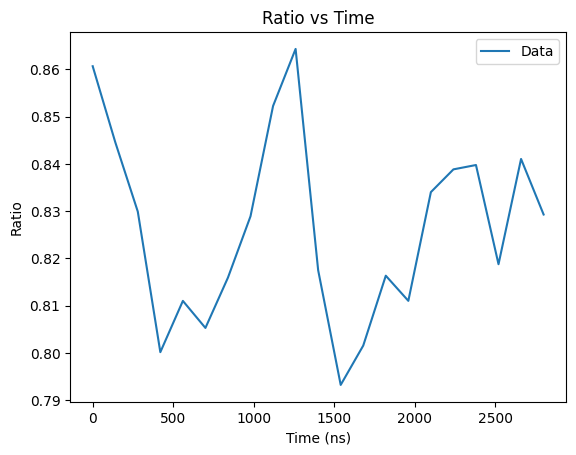

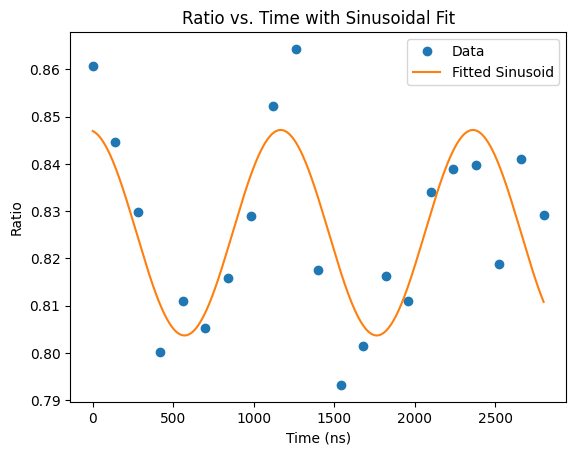

Fitted frequency: 0.0008375287733038038 (in 1/ns)
Fitted period: 1193.9888298467588 ns


In [3]:
# 1. Read the Excel file
df = pd.read_excel("/Users/adampearl/Documents/191/GitHub/nv-center/Second_draft/code/rabi/rabi-29db.xlsx")

# 2. Extract columns for time (x-axis) and ratio (y-axis)
#    Make sure the column names match exactly what is in the file.
time = df["Time (ns) - 2/1 Ratio (Avg)"]
ratio = df["Ratio - 2/1 Ratio (Avg)"]
# 3. Plot the original data
plt.figure()
plt.plot(time, ratio, label='Data')
plt.xlabel('Time (ns)')
plt.ylabel('Ratio')
plt.title('Ratio vs Time')
plt.legend()
plt.show()

# 4. Define a sinusoidal function to fit
#    A = amplitude
#    f = frequency
#    phi = phase
#    C = vertical offset
def sin_func(t, A, f, phi, C):
    return A * np.sin(2 * np.pi * f * t + phi) + C

# 5. Provide initial guesses for the parameters
#    - Amplitude guess from half the data range
#    - Frequency guess might be small
#    - Phase guess = 0
#    - Offset guess from mean of the data
A_guess = (np.max(ratio) - np.min(ratio)) / 2
f_guess = 1e-3  # Adjust as needed
phi_guess = 0
C_guess = np.mean(ratio)
p0 = [A_guess, f_guess, phi_guess, C_guess]

# 6. Fit the data to the sinusoidal function
params, cov = curve_fit(sin_func, time, ratio, p0=p0)

# Extract the fitted parameters
A_fit, f_fit, phi_fit, C_fit = params

# 7. Compute the fitted sinusoid for plotting
time_fit = np.linspace(min(time), max(time), 1000)
ratio_fit = sin_func(time_fit, A_fit, f_fit, phi_fit, C_fit)

# 8. Plot the data and the fitted sinusoid
plt.figure()
plt.plot(time, ratio, 'o', label='Data')
plt.plot(time_fit, ratio_fit, '-', label='Fitted Sinusoid')
plt.xlabel('Time (ns)')
plt.ylabel('Ratio')
plt.title('Ratio vs. Time with Sinusoidal Fit')
plt.legend()
plt.show()

# 9. Print the extracted frequency and period
print(f"Fitted frequency: {f_fit} (in 1/ns)")
print(f"Fitted period: {1.0/f_fit if f_fit != 0 else np.inf} ns")

In [4]:
def frequency(file):
    df = pd.read_excel(file)

    time = df["Time (ns) - 2/1 Ratio (Avg)"]
    ratio = df["Ratio - 2/1 Ratio (Avg)"]

    A_guess = (np.max(ratio) - np.min(ratio)) / 2
    f_guess = 1e-3  # Adjust as needed
    phi_guess = 0
    C_guess = np.mean(ratio)
    p0 = [A_guess, f_guess, phi_guess, C_guess]

    
    params, cov = curve_fit(sin_func, time, ratio, p0=p0)
    
    A_fit, f_fit, phi_fit, C_fit = params
    A_err, f_err, phi_err, offset_err = np.sqrt(np.diag(cov))

   
    time_fit = np.linspace(min(time), max(time), 1000)
    ratio_fit = sin_func(time_fit, A_fit, f_fit, phi_fit, C_fit)

    return f_fit, f_err


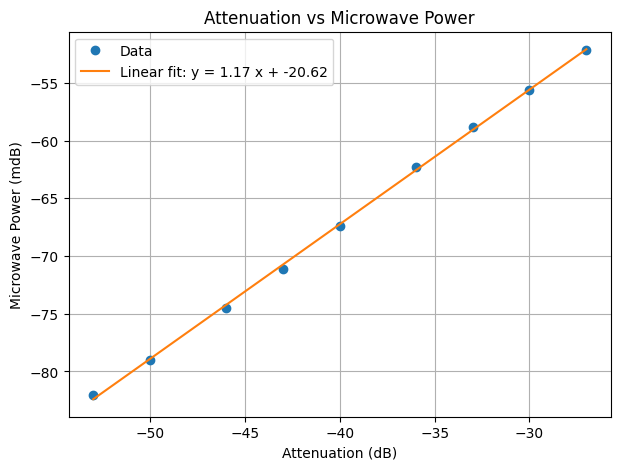

In [5]:

# 1) Your raw data as numpy arrays
attenuation = np.array([-21, -22, -23, -27, -30, -33, -36, -40, -43, -46, -50, -53])
microwave_power = np.array([-51.32, -50.8, -50.9, -52.2, -55.6, -58.8, -62.3, -67.4,
                            -71.1, -74.5, -79.0, -82.0])
attenuation = attenuation[3:]
microwave_power = microwave_power[3:]
# 2) Perform a linear fit using np.polyfit
#    polyfit(x_data, y_data, 1) -> fit a line: y = slope*x + intercept
slope, intercept = np.polyfit(attenuation, microwave_power, 1)

# Create a fitted curve for plotting
x_fit = np.linspace(attenuation.min(), attenuation.max(), 100)
y_fit = slope * x_fit + intercept

# 3) Plot the data
plt.figure(figsize=(7, 5))
plt.plot(attenuation, microwave_power, 'o', label='Data', markersize=6)
plt.plot(x_fit, y_fit, '-', label=f'Linear fit: y = {slope:.2f} x + {intercept:.2f}')

plt.xlabel('Attenuation (dB)')
plt.ylabel('Microwave Power (mdB)')
plt.title('Attenuation vs Microwave Power')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

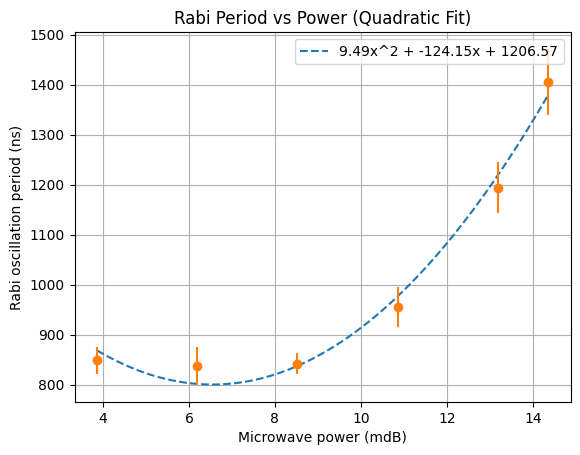

In [6]:
attenuations = np.array([21,23,25,27,29,30])
def attenuation_to_power(attenuation):
    return slope*attenuation + intercept
powers = attenuation_to_power(attenuations)

periods = []
errors = []
for a in attenuations:
    file = f"/Users/adampearl/Documents/191/GitHub/nv-center/Second_draft/code/rabi/rabi-{str(a)}db.xlsx"
    freq, f_err = frequency(file)
    period = 1/freq 
    error = f_err / freq**2
    periods.append(period)
    errors.append(error)

coefs = np.polyfit(powers, periods, 2)  
powers_fit = np.linspace(powers.min(), powers.max(), 200)
periods_fit = np.polyval(coefs, powers_fit)
plt.plot(powers_fit, periods_fit, '--', label=f'{coefs[0]:.2f}x^2 + {coefs[1]:.2f}x + {coefs[2]:.2f}')

plt.errorbar(powers, periods, errors, fmt='o',)
plt.xlabel("Microwave power attenuation (db)")
plt.ylabel("Rabi oscillation period (ns)")
plt.xlabel("Microwave power (mdB)")
plt.ylabel("Rabi oscillation period (ns)")
plt.title("Rabi Period vs Power (Quadratic Fit)")
plt.legend()
plt.grid(True)
plt.show()

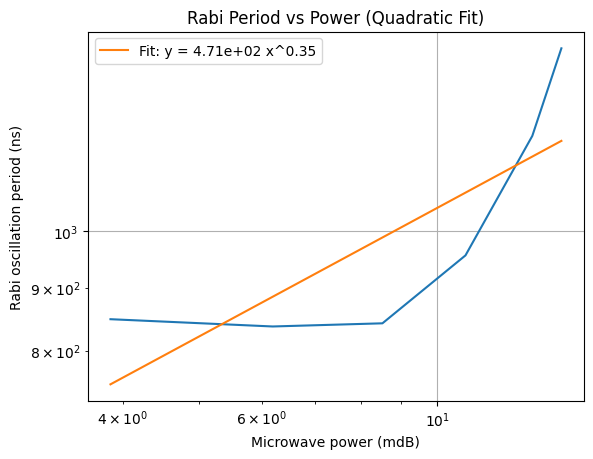

In [11]:
slope, intercept = np.polyfit(np.log(powers), np.log(periods), 1)

alpha_fit = slope
A_fit = np.exp(intercept)
# Generate a smooth curve for plotting the fit
x_fit = np.linspace(min(powers), max(powers), 500)
y_fit = A_fit * x_fit**alpha_fit


plt.loglog(powers, periods)
plt.plot(x_fit, y_fit, '-', label=f'Fit: y = {A_fit:.2e} x^{alpha_fit:.2f}')  # fitted curve

plt.xlabel("Microwave power attenuation (db)")
plt.ylabel("Rabi oscillation period (ns)")
plt.xlabel("Microwave power (mdB)")
plt.ylabel("Rabi oscillation period (ns)")
plt.title("Rabi Period vs Power (Quadratic Fit)")
# plt.xscale('log')
# plt.yscale('log')
plt.legend()
plt.grid(True)
plt.show()



In [ ]:
output_power = (input_power + 45*dbm )* 10**(attenuation/10)